# Taxi Trip Time Prediction

To improve the efficiency of electronic taxi dispatching systems it is important to be able to predict how long a driver will have his taxi occupied. If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

## Importing Needed Packages

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn as sk

## Reading the Data

In [2]:
dataframe = pd.read_csv("train.csv")

Get a look into the first few lines.

In [3]:
dataframe.head()

TRIP_ID CALL_TYPE  ORIGIN_CALL  ORIGIN_STAND   TAXI_ID  \
0  1372636858620000589         C          NaN           NaN  20000589   
1  1372637303620000596         B          NaN             7  20000596   
2  1372636951620000320         C          NaN           NaN  20000320   
3  1372636854620000520         C          NaN           NaN  20000520   
4  1372637091620000337         C          NaN           NaN  20000337   

    TIMESTAMP DAY_TYPE MISSING_DATA  \
0  1372636858        A        False   
1  1372637303        A        False   
2  1372636951        A        False   
3  1372636854        A        False   
4  1372637091        A        False   

                                            POLYLINE  
0  [[-8.618643,41.141412],[-8.618499,41.141376],[...  
1  [[-8.639847,41.159826],[-8.640351,41.159871],[...  
2  [[-8.612964,41.140359],[-8.613378,41.14035],[-...  
3  [[-8.574678,41.151951],[-8.574705,41.151942],[...  
4  [[-8.645994,41.18049],[-8.645949,41.180517],[-...  

[5 rows x 9 columns]

## Understanding the Data

The Dataset represents a complete year (from 01/07/2013 to 30/06/2014) of the trajectories for all the 442 taxis running in the city of Porto, in Portugal.<br>
Each data sample corresponds to one completed trip. It contains a total of 
9 (nine) features, described as follows:

<b>TRIP_ID</b>: (String) It contains an unique identifier for each trip.<br>
<b>CALL_TYPE</b>: (char) It identifies the way used to demand this service. It may contain one of three possible values:<br>
‘A’ if this trip was dispatched from the central;<br>
‘B’ if this trip was demanded directly to a taxi driver on a specific stand;<br>
‘C’ otherwise (i.e. a trip demanded on a random street).<br>
<b>ORIGIN_CALL</b>: (integer) It contains an unique identifier for each phone number which was used to demand, at least, one service. It identifies the trip’s customer if CALL_TYPE=’A’. Otherwise, it assumes a NULL value;<br>
<b>ORIGIN_STAND</b>: (integer): It contains an unique identifier for the taxi stand. It identifies the starting point of the trip if CALL_TYPE=’B’. Otherwise, it assumes a NULL value;<br>
<b>TAXI_ID</b>: (integer): It contains an unique identifier for the taxi driver that performed each trip;<br>
<b>TIMESTAMP</b>: (integer) Unix Timestamp (in seconds). It identifies the trip’s start;<br> 
<b>DAYTYPE</b>: (char) It identifies the daytype of the trip’s start. It assumes one of three possible values:<br>
‘B’ if this trip started on a holiday or any other special day (i.e. extending holidays, floating holidays, etc.);<br>
‘C’ if the trip started on a day before a type-B day;<br>
‘A’ otherwise (i.e. a normal day, workday or weekend).<br>
<b>MISSING_DATA</b>: (Boolean) It is FALSE when the GPS data stream is complete and TRUE whenever one (or more) locations are missing<br>
<b>POLYLINE</b>: (String): It contains a list of GPS coordinates (i.e. WGS84 format) mapped as a string. The beginning and the end of the string are identified with brackets (i.e. [ and ], respectively). Each pair of coordinates is also identified by the same brackets as [LONGITUDE, LATITUDE]. This list contains one pair of coordinates for each 15 seconds of trip. The last list item corresponds to the trip’s destination while the first one represents its start;<br>

### Primary Preprocessing

We can obsereve there is a number of features that are not related to the trip time as the TRIP_ID, CALL_TYPE, ORIGIN_CALL and ORIGIN_STAND.

In [4]:
dataframe = dataframe.drop(['TRIP_ID', 'CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND'],axis=1)

The day time has a great potential to affect the trip time, whether it's a normal day or a workday or a holiday would definitely affect the time taken by the taxi. 

In [5]:
dataframe['DAY_TYPE'].unique()

array(['A'], dtype=object)

It appears that all the days through the year are considered as Type A. Therefore, this feature is not considered helpful anymore and most probably the timestamp will be the same.

In [6]:
dataframe = dataframe.drop(['DAY_TYPE','TIMESTAMP'],axis=1)

The next step is to explore the effect of the missing data.

In [7]:
print len(dataframe[dataframe['MISSING_DATA'] == True])
print len(dataframe)

10
1710670


The records containing missing data are only 10 within more than a million record so it can be ignored.

In [8]:
dataframe = dataframe[dataframe['MISSING_DATA'] == False]
dataframe = dataframe.drop('MISSING_DATA',axis =1)

A million record will take so much time for training so we will take a subset of 200k record.

In [9]:
dataframe = dataframe.head(n=200000)

## Exploring the Data After Preprocessing

In [10]:
dataframe.head()

TAXI_ID                                           POLYLINE
0  20000589  [[-8.618643,41.141412],[-8.618499,41.141376],[...
1  20000596  [[-8.639847,41.159826],[-8.640351,41.159871],[...
2  20000320  [[-8.612964,41.140359],[-8.613378,41.14035],[-...
3  20000520  [[-8.574678,41.151951],[-8.574705,41.151942],[...
4  20000337  [[-8.645994,41.18049],[-8.645949,41.180517],[-...

[5 rows x 2 columns]

The total travel time of the trip (the prediction target of this competition) is defined as the (number of points-1) x 15 seconds.

In [11]:
def compute_time(x):
    return (len(eval(x))-1)*15

In [12]:
dataframe['Time'] = dataframe['POLYLINE'].apply(lambda x: compute_time(x))

In [13]:
len(dataframe[dataframe['Time'] == 0])

2512

We can obsereve that there are some records with only one point and no missing data so we have to exclude them as they are not considered as trips

In [14]:
dataframe = dataframe[dataframe['Time'] > 0]

Exploring the Time Distribution

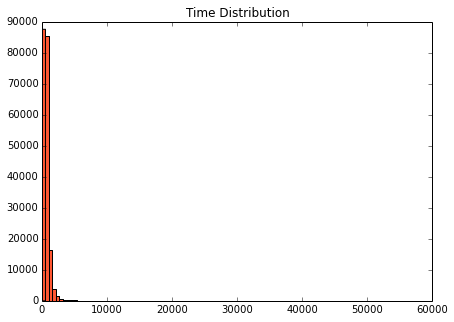

In [15]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['font.size'] = 10
plot  = plt.hist(dataframe['Time'].values, bins=100,color='#FF5733')
plot = plt.title('Time Distribution')

We can observe that there are some trips that exceeds the 10000 to 60000 which means from around 3 hours to around 16 hours.<br>

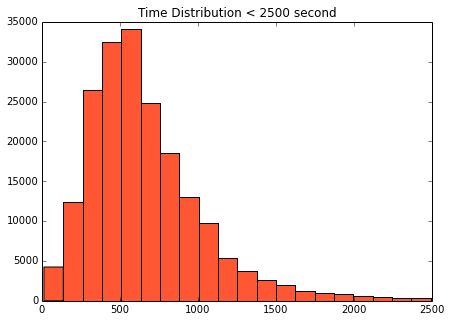

In [16]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['font.size'] = 10
plot  = plt.hist(dataframe[dataframe['Time']<2500]['Time'].values, bins=20,color='#FF5733')
plot = plt.title('Time Distribution < 2500 second')

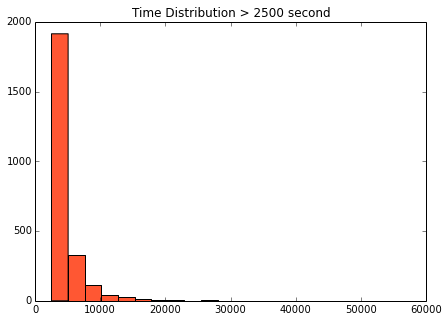

In [17]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['font.size'] = 10
plot  = plt.hist(dataframe[dataframe['Time']>2500]['Time'].values, bins=20,color='#FF5733')
plot = plt.title('Time Distribution > 2500 second')

We can observe that most of the trips are with 500 to 1000 seconds which are 9 to 15 minutes. In order to have a better model we can exclude very long and very short trips.<br>
Long trips can be considered the ones with greater than 2000 seconds and the short ones with less than a minute.

In [74]:
dataframe = dataframe[dataframe['Time'] < 2000]
dataframe = dataframe[dataframe['Time'] > 120]

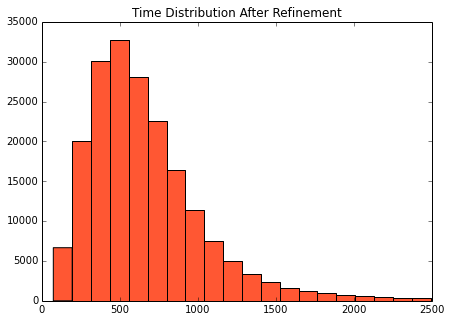

In [19]:
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['font.size'] = 10
plot  = plt.hist(dataframe['Time'].values, bins=20,color='#FF5733')
plot = plt.title('Time Distribution After Refinement')

### The Taxi Driver Effect

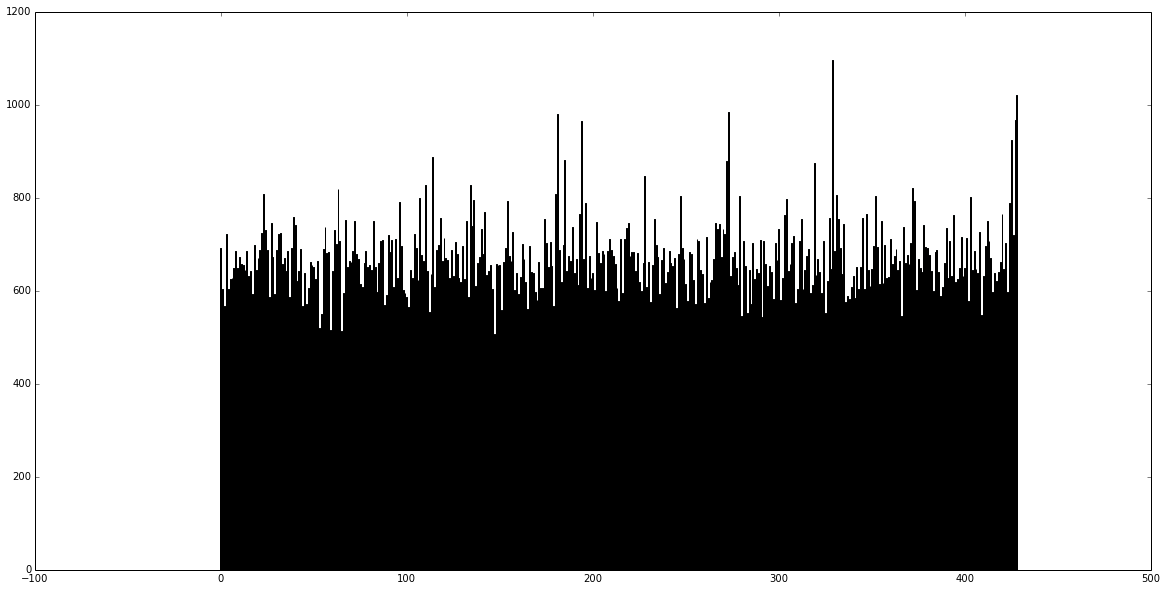

In [20]:
taxi_time_data  = dataframe[['TAXI_ID','Time']].groupby('TAXI_ID').mean()

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 10

taxi_time_values  = taxi_time_data['Time']
taxi_time_values_list = taxi_time_values.tolist()

plot  = plt.bar(list(xrange(len(taxi_time_values_list))),taxi_time_values_list,0.5, color='#33A2FF', align='center')


We can obsereve that most of the taxi drivers have the same average trip time but the average time taken by each driver may be a good feature.

In [21]:
def compute_average_driver_time(x,y):
    result = y[x]
    return result

In [22]:
dataframe['DriverTime'] = dataframe['TAXI_ID'].apply(
    lambda x: compute_average_driver_time(x,taxi_time_values))

In [23]:
dataframe = dataframe.drop('TAXI_ID',axis=1)

### Feature Engineering from the GPS Path

Valuable Features can be extracted from the path and may have good potential as the Euclidean distance, Total distance , starting and finish points.

In [24]:
def compute_euclidean_distance(x):
    points_list = eval(x)
    size = len(points_list)
    starting_point = points_list[0]
    end_point = points_list[size -1 ]
    
    return np.linalg.norm(np.array(starting_point) - np.array(end_point))

In [25]:
dataframe['EuclideanDistance'] = dataframe['POLYLINE'].apply(lambda x:
                                                            compute_euclidean_distance(x))

In [26]:
def compute_total_distance(x):
    points_list = eval(x)
    size = len(points_list)
    distance = 0
    for i in range(size - 1):
        distance += np.linalg.norm(np.array(points_list[i]) - np.array(points_list[i+1]))
    return distance

In [27]:
dataframe['TotalDistance'] = dataframe['POLYLINE'].apply(lambda x:
                                                            compute_total_distance(x))

In [28]:
def compute_starting_point_x(x):
    points_list = eval(x)
    return points_list[0][0]

In [29]:
def compute_starting_point_y(x):
    points_list = eval(x)
    return points_list[0][1]

In [30]:
def compute_end_point_x(x):
    points_list = eval(x)
    return points_list[len(points_list) -1][0]

In [31]:
def compute_end_point_y(x):
    points_list = eval(x)
    return points_list[len(points_list) -1][1]

In [32]:
dataframe['StartingX'] = dataframe['POLYLINE'].apply(lambda x: compute_starting_point_x(x))
dataframe['StartingY'] = dataframe['POLYLINE'].apply(lambda x: compute_starting_point_y(x))
dataframe['EndX'] = dataframe['POLYLINE'].apply(lambda x: compute_end_point_x(x))
dataframe['EndY'] = dataframe['POLYLINE'].apply(lambda x: compute_end_point_y(x))

In [33]:
dataframe.head()

POLYLINE  Time  DriverTime  \
0  [[-8.618643,41.141412],[-8.618499,41.141376],[...   330  628.494094   
1  [[-8.639847,41.159826],[-8.640351,41.159871],[...   270  675.052632   
2  [[-8.612964,41.140359],[-8.613378,41.14035],[-...   960  675.648000   
3  [[-8.574678,41.151951],[-8.574705,41.151942],[...   630  640.414508   
4  [[-8.645994,41.18049],[-8.645949,41.180517],[-...   420  687.072617   

   EuclideanDistance  TotalDistance  StartingX  StartingY      EndX       EndY  
0           0.017881       0.028718  -8.618643  41.141412 -8.630838  41.154489  
1           0.028072       0.039557  -8.639847  41.159826 -8.665740  41.170671  
2           0.003011       0.201938  -8.612964  41.140359 -8.615970  41.140530  
3           0.034522       0.091168  -8.574678  41.151951 -8.607996  41.142915  
4           0.041344       0.053230  -8.645994  41.180490 -8.687268  41.178087  

[5 rows x 9 columns]

One Interesting observation that X coordinates and Y coordinates are centered around 8 and 41. A deeper look is needed

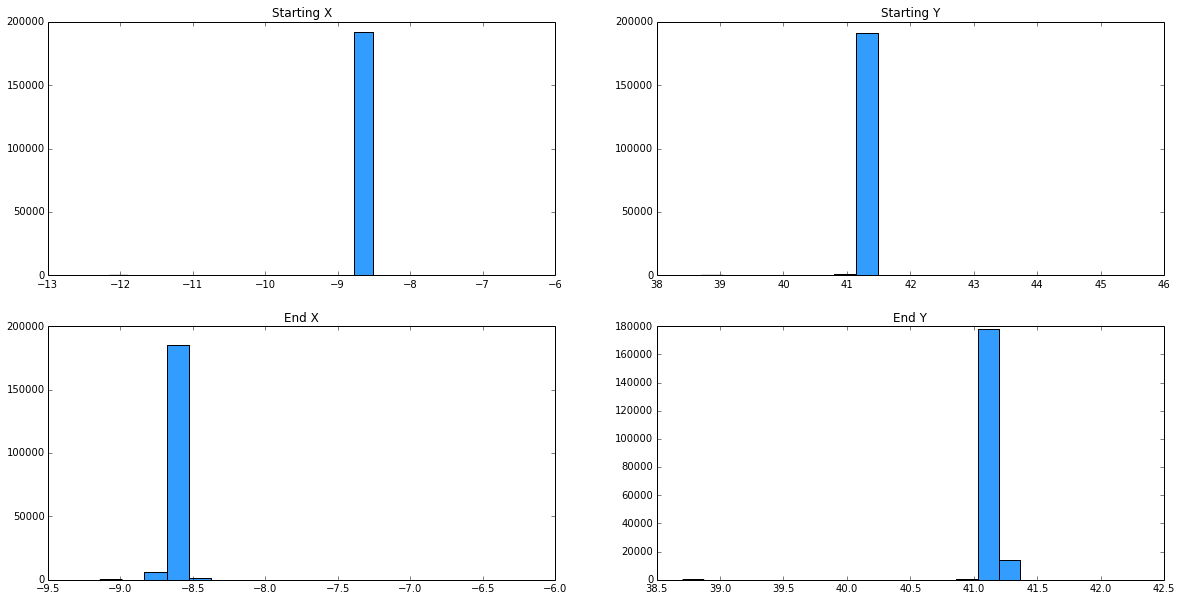

In [34]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 10

plt.subplot(221)
plt.hist(dataframe['StartingX'], bins=20, color = '#339CFF')
plt.title('Starting X')

plt.subplot(222)
plt.hist(dataframe['StartingY'], bins=20, color = '#339CFF')
plt.title('Starting Y')

plt.subplot(223)
plt.hist(dataframe['EndX'], bins=20, color = '#339CFF')
plt.title('End X')

plt.subplot(224)
plt.hist(dataframe['EndY'], bins=20, color = '#339CFF')
plt.title('End Y')

In order to have more meaningful feature about the position. We can focus on the variations after the decimal point.

In [35]:
dataframe['StartingX'] = dataframe['StartingX'].apply(lambda x: (x +8)*10)
dataframe['StartingY'] = dataframe['StartingY'].apply(lambda x: (x -41)*10)
dataframe['EndX'] = dataframe['EndX'].apply(lambda x: (x +8)*10)
dataframe['EndY'] = dataframe['EndY'].apply(lambda x: (x -41)*10)

In [36]:
dataframe.head()

POLYLINE  Time  DriverTime  \
0  [[-8.618643,41.141412],[-8.618499,41.141376],[...   330  628.494094   
1  [[-8.639847,41.159826],[-8.640351,41.159871],[...   270  675.052632   
2  [[-8.612964,41.140359],[-8.613378,41.14035],[-...   960  675.648000   
3  [[-8.574678,41.151951],[-8.574705,41.151942],[...   630  640.414508   
4  [[-8.645994,41.18049],[-8.645949,41.180517],[-...   420  687.072617   

   EuclideanDistance  TotalDistance  StartingX  StartingY     EndX     EndY  
0           0.017881       0.028718   -6.18643    1.41412 -6.30838  1.54489  
1           0.028072       0.039557   -6.39847    1.59826 -6.65740  1.70671  
2           0.003011       0.201938   -6.12964    1.40359 -6.15970  1.40530  
3           0.034522       0.091168   -5.74678    1.51951 -6.07996  1.42915  
4           0.041344       0.053230   -6.45994    1.80490 -6.87268  1.78087  

[5 rows x 9 columns]

The calculated distance also can be multiplied by hundered for better resolution.

In [37]:
dataframe['EuclideanDistance'] = dataframe['EuclideanDistance'] * 1000
dataframe['TotalDistance'] = dataframe['TotalDistance'] * 1000

In [38]:
dataframe.head()

POLYLINE  Time  DriverTime  \
0  [[-8.618643,41.141412],[-8.618499,41.141376],[...   330  628.494094   
1  [[-8.639847,41.159826],[-8.640351,41.159871],[...   270  675.052632   
2  [[-8.612964,41.140359],[-8.613378,41.14035],[-...   960  675.648000   
3  [[-8.574678,41.151951],[-8.574705,41.151942],[...   630  640.414508   
4  [[-8.645994,41.18049],[-8.645949,41.180517],[-...   420  687.072617   

   EuclideanDistance  TotalDistance  StartingX  StartingY     EndX     EndY  
0          17.880882      28.718316   -6.18643    1.41412 -6.30838  1.54489  
1          28.072433      39.557333   -6.39847    1.59826 -6.65740  1.70671  
2           3.010860     201.938022   -6.12964    1.40359 -6.15970  1.40530  
3          34.521565      91.167828   -5.74678    1.51951 -6.07996  1.42915  
4          41.343893      53.230179   -6.45994    1.80490 -6.87268  1.78087  

[5 rows x 9 columns]

In [39]:
polyline = dataframe['POLYLINE']
dataframe = dataframe.drop('POLYLINE',axis=1)

Exploring the coorelation betweeen features.

In [40]:
dataframe.corr()

Time  DriverTime  EuclideanDistance  TotalDistance  \
Time               1.000000    0.181379           0.467307       0.646619   
DriverTime         0.181379    1.000000           0.054407       0.107518   
EuclideanDistance  0.467307    0.054407           1.000000       0.832860   
TotalDistance      0.646619    0.107518           0.832860       1.000000   
StartingX         -0.029498   -0.017405          -0.197919      -0.114035   
StartingY          0.023016   -0.012081           0.169881       0.119212   
EndX              -0.074692   -0.022442          -0.094342      -0.115289   
EndY               0.182793    0.039710           0.360619       0.358957   

                   StartingX  StartingY      EndX      EndY  
Time               -0.029498   0.023016 -0.074692  0.182793  
DriverTime         -0.017405  -0.012081 -0.022442  0.039710  
EuclideanDistance  -0.197919   0.169881 -0.094342  0.360619  
TotalDistance      -0.114035   0.119212 -0.115289  0.358957  
StartingX           1.000000  -0.091030  0.269330  0.024223  
StartingY          -0.091030   1.000000  0.049323  0.270298  
EndX                0.269330   0.049323  1.000000 -0.206043  
EndY                0.024223   0.270298 -0.206043  1.000000  

[8 rows x 8 columns]

Adding New features and Exploring the coorelation.

In [41]:
dataframe['TotalDistance2'] = dataframe['TotalDistance'].apply(lambda x: x*x)
dataframe['EuclideanDistance2'] = dataframe['EuclideanDistance'].apply(lambda x: x*x)
dataframe['MixedDistance'] = dataframe['TotalDistance']*dataframe['EuclideanDistance']

In [42]:
dataframe.corr()

Time  DriverTime  EuclideanDistance  TotalDistance  \
Time                1.000000    0.181379           0.467307       0.646619   
DriverTime          0.181379    1.000000           0.054407       0.107518   
EuclideanDistance   0.467307    0.054407           1.000000       0.832860   
TotalDistance       0.646619    0.107518           0.832860       1.000000   
StartingX          -0.029498   -0.017405          -0.197919      -0.114035   
StartingY           0.023016   -0.012081           0.169881       0.119212   
EndX               -0.074692   -0.022442          -0.094342      -0.115289   
EndY                0.182793    0.039710           0.360619       0.358957   
TotalDistance2      0.092604    0.018302           0.572076       0.459527   
EuclideanDistance2  0.030295    0.005107           0.526548       0.345823   
MixedDistance       0.047288    0.008287           0.548247       0.374906   

                    StartingX  StartingY      EndX      EndY  TotalDistance2  \
Time                -0.029498   0.023016 -0.074692  0.182793        0.092604   
DriverTime          -0.017405  -0.012081 -0.022442  0.039710        0.018302   
EuclideanDistance   -0.197919   0.169881 -0.094342  0.360619        0.572076   
TotalDistance       -0.114035   0.119212 -0.115289  0.358957        0.459527   
StartingX            1.000000  -0.091030  0.269330  0.024223       -0.353299   
StartingY           -0.091030   1.000000  0.049323  0.270298        0.344044   
EndX                 0.269330   0.049323  1.000000 -0.206043        0.026927   
EndY                 0.024223   0.270298 -0.206043  1.000000        0.057188   
TotalDistance2      -0.353299   0.344044  0.026927  0.057188        1.000000   
EuclideanDistance2  -0.364954   0.352984  0.033951  0.021907        0.978581   
MixedDistance       -0.363384   0.351210  0.031751  0.034619        0.984215   

                    EuclideanDistance2  MixedDistance  
Time                          0.030295       0.047288  
DriverTime                    0.005107       0.008287  
EuclideanDistance             0.526548       0.548247  
TotalDistance                 0.345823       0.374906  
StartingX                    -0.364954      -0.363384  
StartingY                     0.352984       0.351210  
EndX                          0.033951       0.031751  
EndY                          0.021907       0.034619  
TotalDistance2                0.978581       0.984215  
EuclideanDistance2            1.000000       0.999252  
MixedDistance                 0.999252       1.000000  

[11 rows x 11 columns]

The added features were not helpful so we will discard them.

In [43]:
dataframe = dataframe.drop(['TotalDistance2','EuclideanDistance2','MixedDistance'],axis=1)

## Visualizing Coorelation

/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


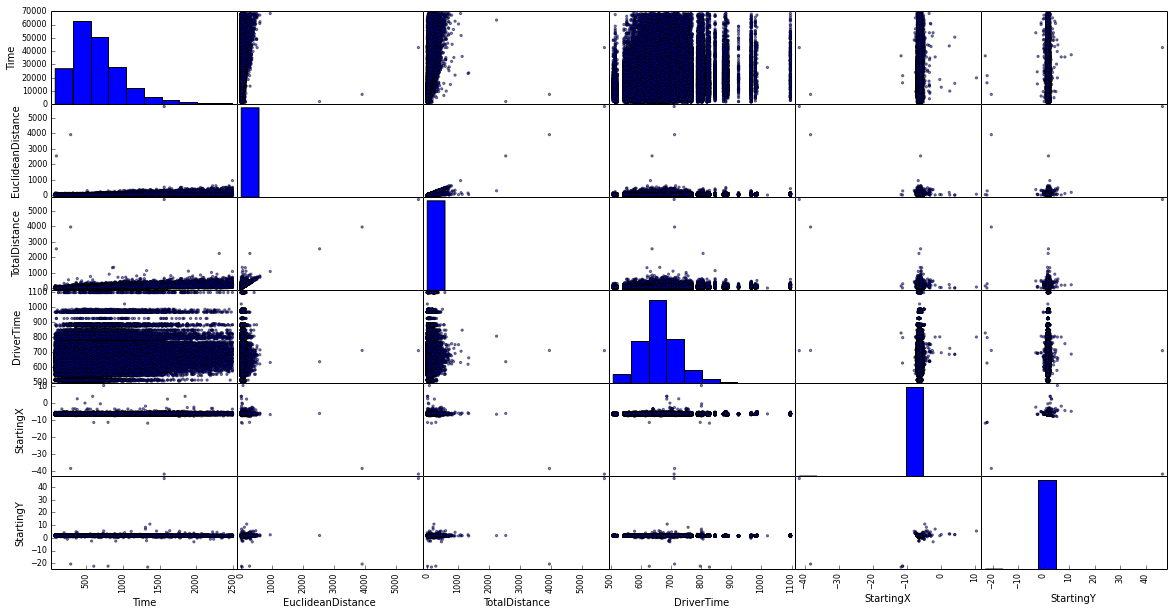

In [44]:
plot = pd.scatter_matrix(dataframe[['Time','EuclideanDistance','TotalDistance','DriverTime',
                                   'StartingX','StartingY']])

One very interesting and important obserevation is the existance of outliers. We can easily observe around 4 points ( from 200,000) with very large distances.<br>

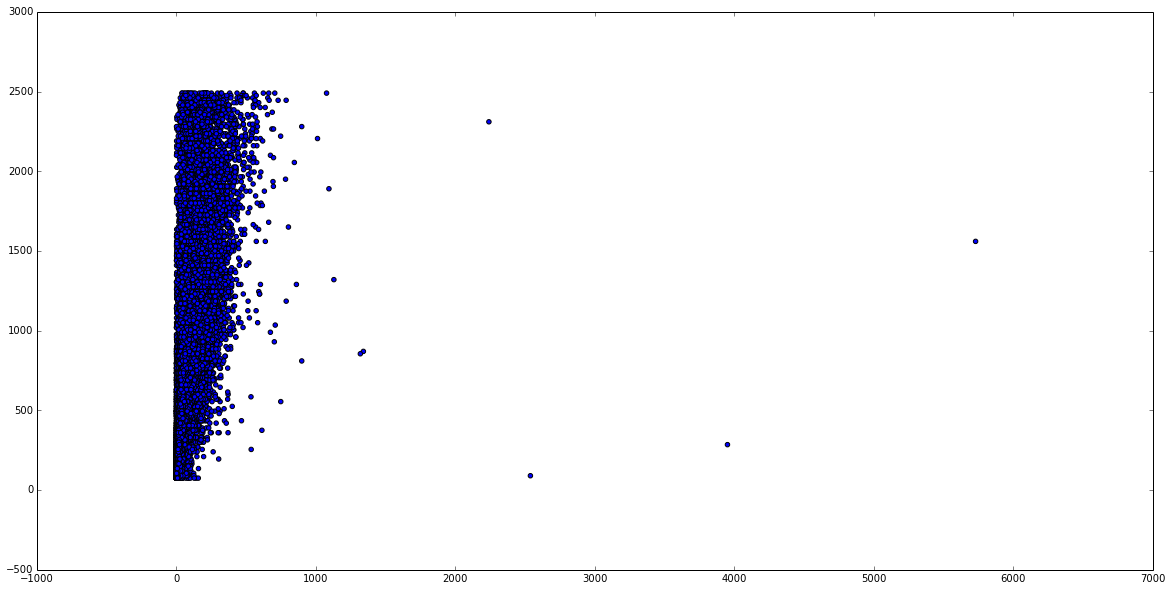

In [45]:
plot =plt.scatter(dataframe['TotalDistance'].values,dataframe['Time'].values)

A primary step to remove outliers with large total distances is to remove records with distances greater than 1000.

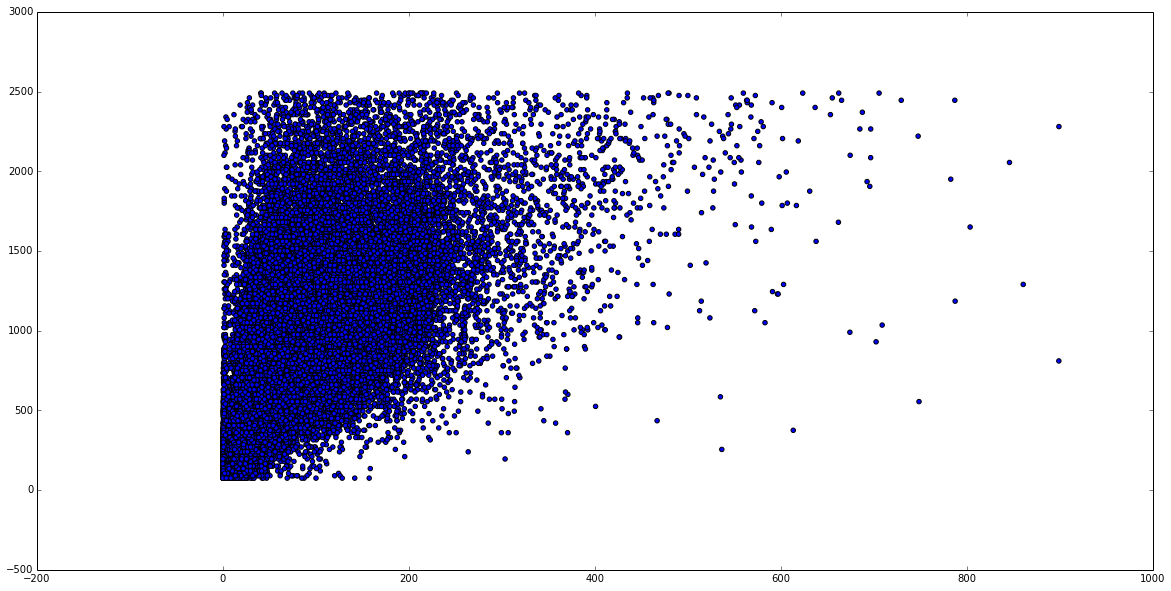

In [48]:
dataframe = dataframe[dataframe['TotalDistance'] < 1000]
plot =plt.scatter(dataframe['TotalDistance'].values,dataframe['Time'].values)

Most of the points are still concentrated between 0 and 400, so more reduction maybe useful.

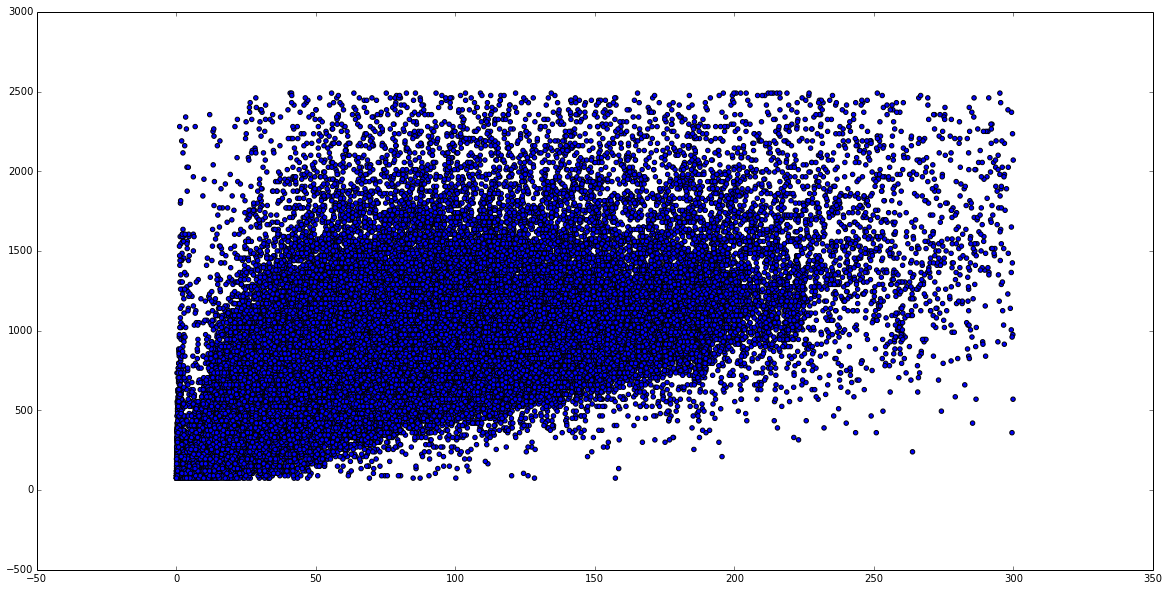

In [70]:
dataframe = dataframe[dataframe['TotalDistance'] < 300]
plot =plt.scatter(dataframe['TotalDistance'].values,dataframe['Time'].values)

We also have to look at the obsereved outliers with the starting X and Y.

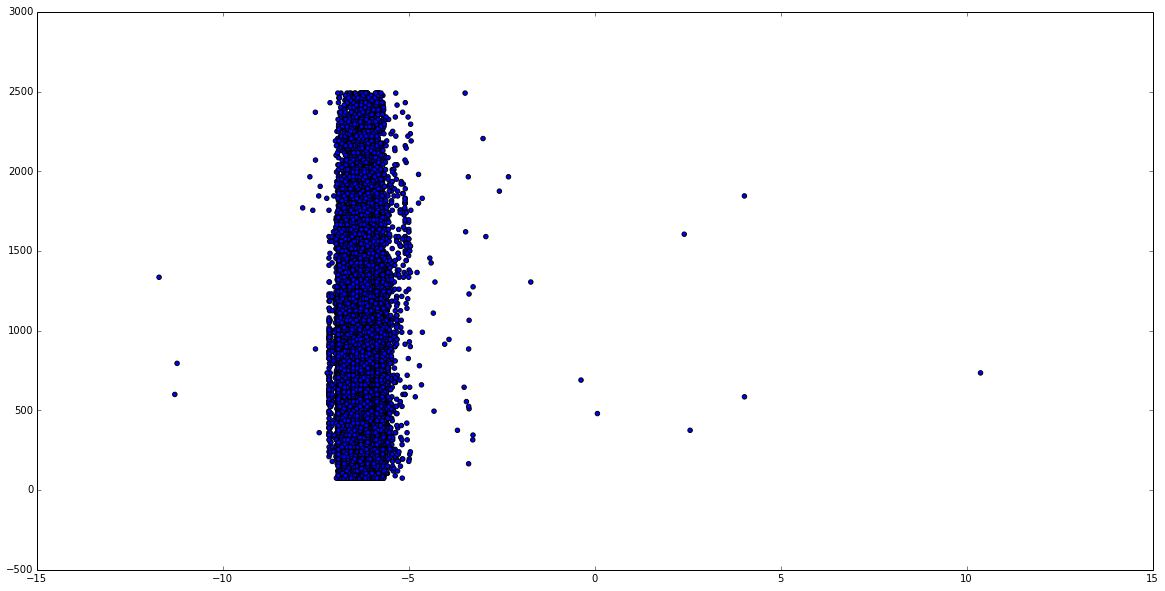

In [51]:
plot =plt.scatter(dataframe['StartingX'].values,dataframe['Time'].values)

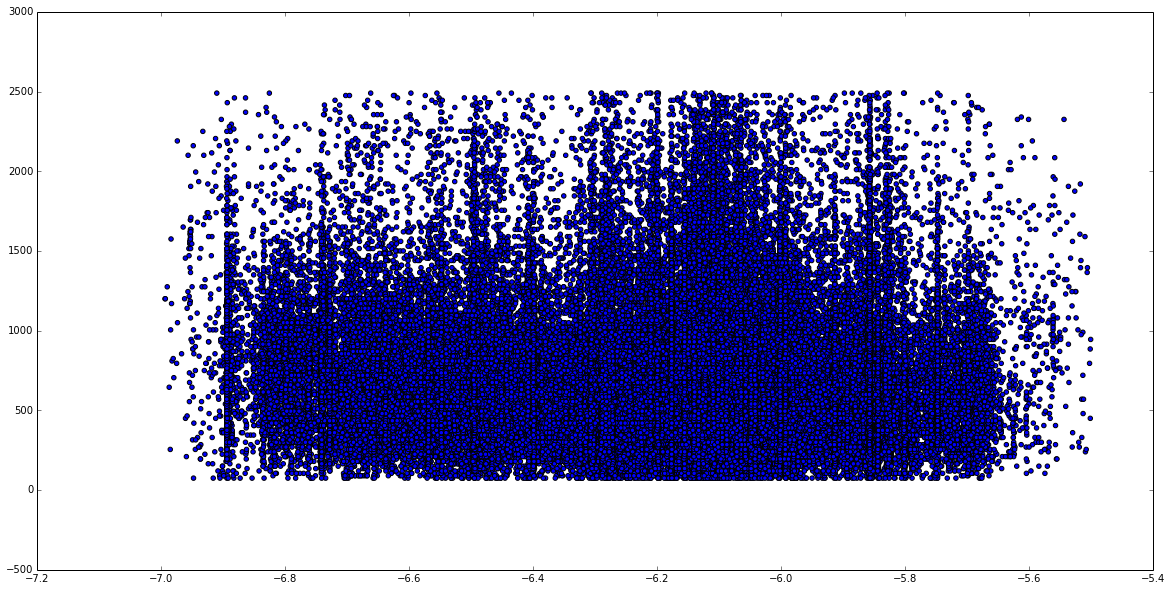

In [53]:
dataframe = dataframe[dataframe['StartingX'] < -5.5]
dataframe = dataframe[dataframe['StartingX'] > -7]
plot =plt.scatter(dataframe['StartingX'].values,dataframe['Time'].values)

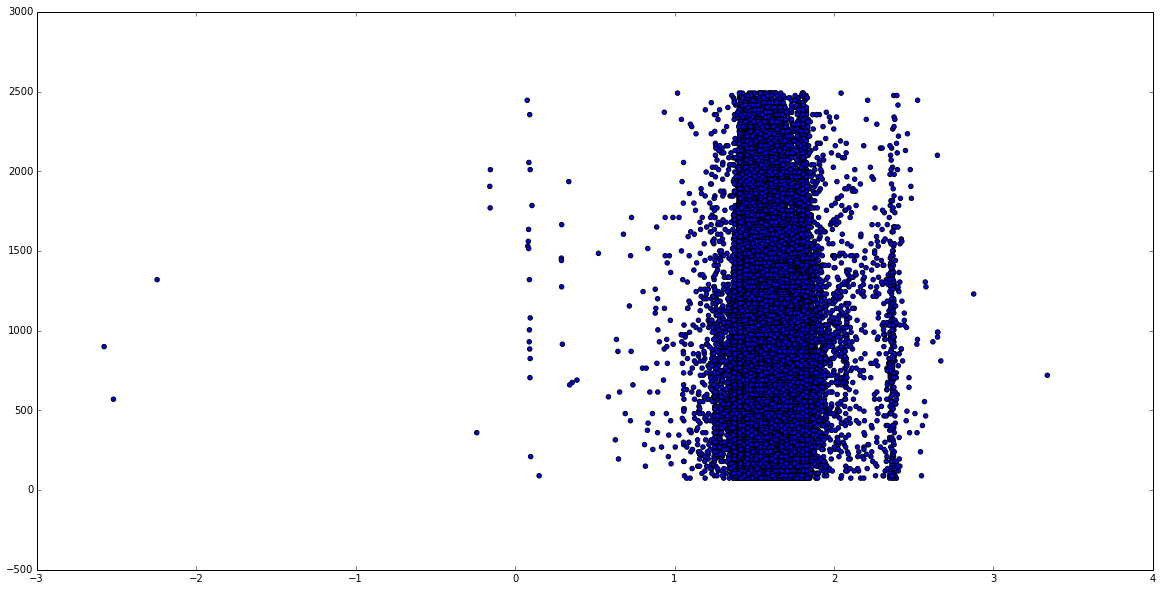

In [54]:
plot =plt.scatter(dataframe['StartingY'].values,dataframe['Time'].values)

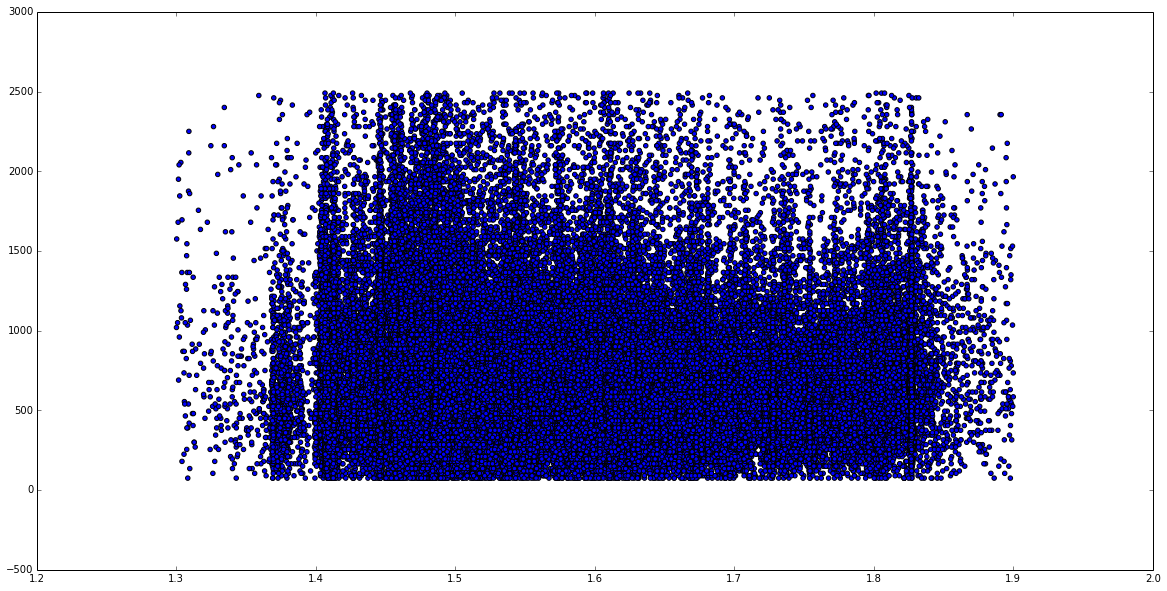

In [57]:
dataframe = dataframe[dataframe['StartingY'] < 1.9]
dataframe = dataframe[dataframe['StartingY'] > 1.3]
plot =plt.scatter(dataframe['StartingY'].values,dataframe['Time'].values)

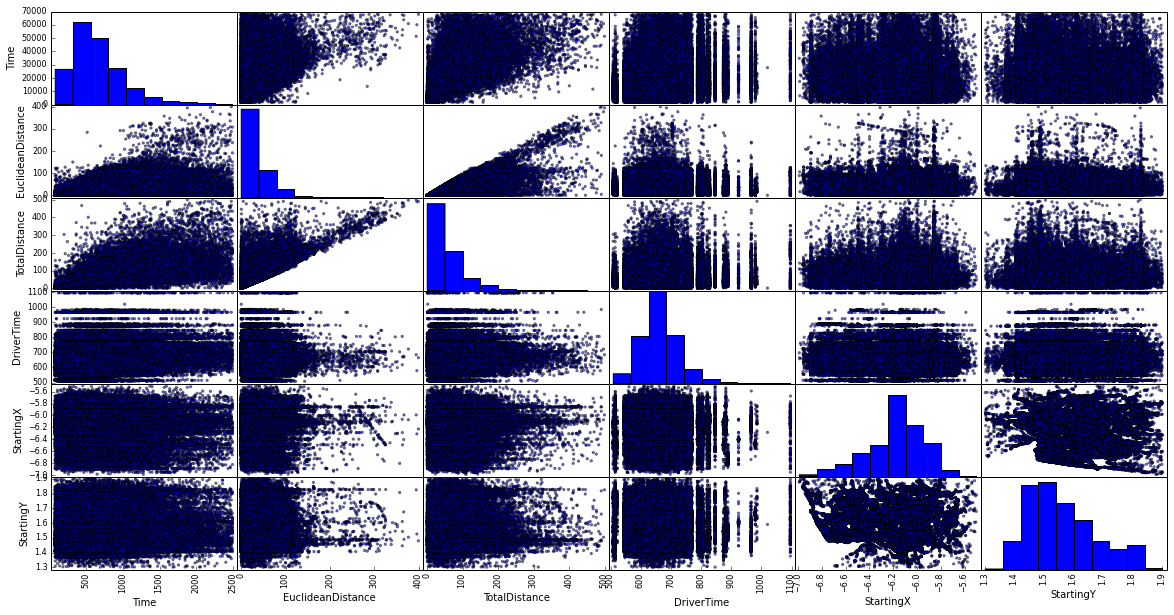

In [59]:
plot = pd.scatter_matrix(dataframe[['Time','EuclideanDistance','TotalDistance','DriverTime',
                                   'StartingX','StartingY']])

The Filtered Data can be considered without outliers.

## Prediction

### Linear Regression

In [75]:
from sklearn import cross_validation
targets = dataframe['Time'].values
features = dataframe.drop(['Time'],axis=1).values
train_data, test_data, train_targets, test_targets =cross_validation.train_test_split(
    features, targets, test_size=0.2, random_state=0)

In [76]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model = model.fit(train_data,train_targets)
prediction = model.predict(test_data)

In [77]:
from sklearn.metrics import mean_squared_error
mean_squared_error(prediction, test_targets)

54727.762653094622

The Error is very large compared to values so there must be an outlier but in order to figure it out we can plot it.

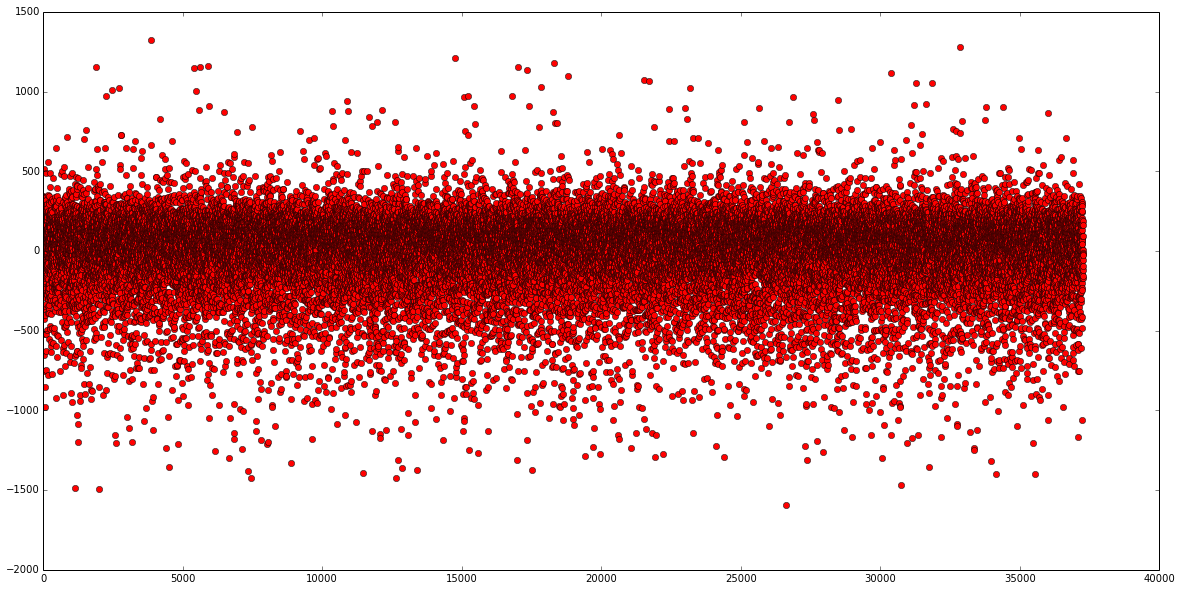

In [79]:
plt.plot(error,'ro')

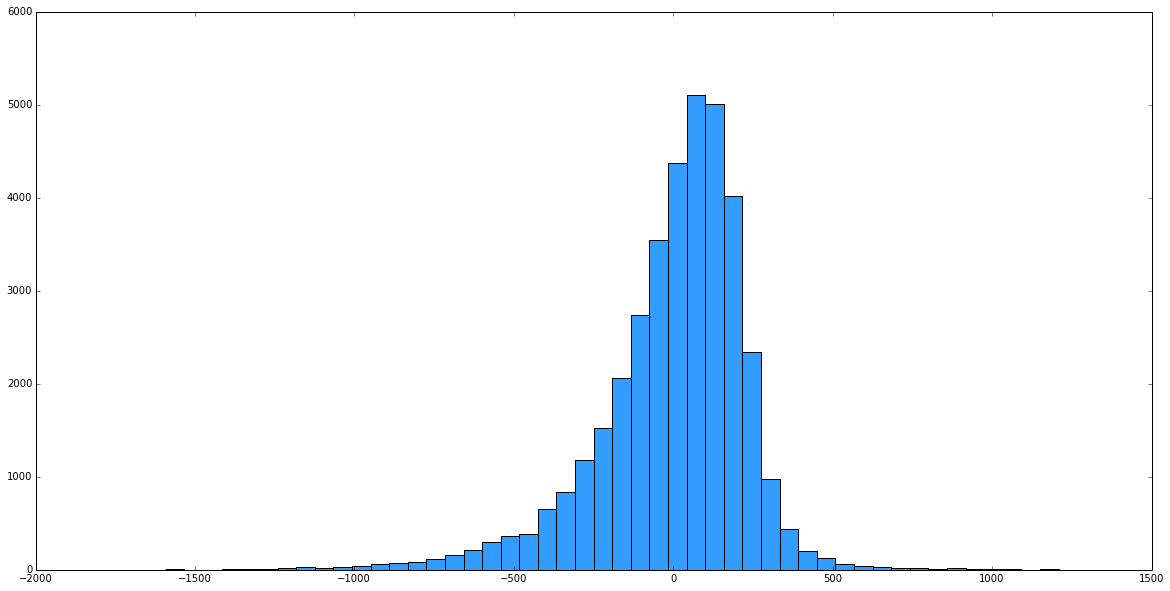

In [80]:
error = prediction - test_targets
plot = plt.hist(error, bins=50, color = '#339CFF')

### Nearset Neighbors

In [81]:
from sklearn.neighbors import KNeighborsRegressor
nn_model = KNeighborsRegressor(n_neighbors=5)
nn_model = nn_model.fit(train_data,train_targets)
prediction2 = nn_model.predict(test_data)

In [82]:
mean_squared_error(prediction2, test_targets)

52220.227598422025

### Decision Tree

In [83]:
from sklearn.tree import DecisionTreeRegressor
model_dt  = DecisionTreeRegressor(max_depth=8)
model_dt = model_dt.fit(train_data,train_targets)
prediction3 = model_dt.predict(test_data)

In [84]:
mean_squared_error(prediction3, test_targets)

45991.723777471445

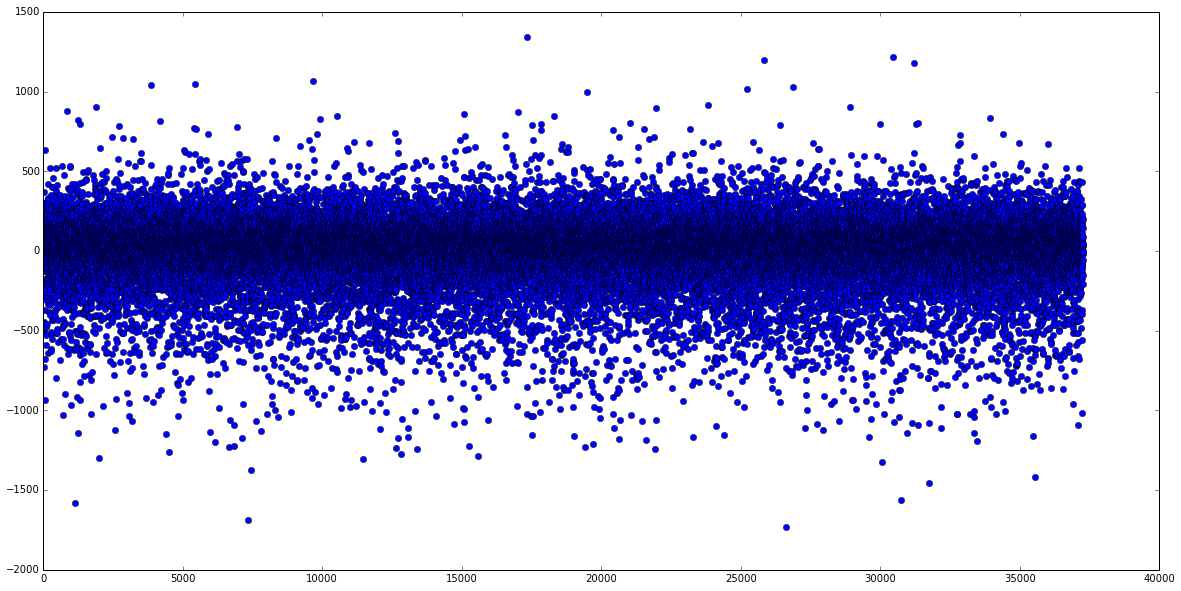

In [85]:
plt.plot(prediction3 - test_targets,'bo')